In [4]:
%pip install -q tf2onnx onnx "protobuf>=5.28.0" "flatbuffers>=24.3.25"

Note: you may need to restart the kernel to use updated packages.


c:\Users\pmelto1\AppData\Local\miniconda3\envs\life-optimizer-tf2\lib\site-packages\tf2onnx\utils.py:49: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  onnx_pb.TensorProto.STRING: np.object,
C:\Users\pmelto1\AppData\Local\Temp\ipykernel_28164\2614725774.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  journal_df['Answered yes'] = journal_df['Answered yes'].astype(str).str.lower().map({'true': 1, 'false': 0})



--- Compute Devices ---
TensorFlow device: CPU - /physical_device:CPU:0
Note: Intel AI Boost NPU is used via ONNX Runtime + OpenVINO for inference.
Loading data...
Processing Physiological Cycles...
Processing Sleeps...
Processing Journal Entries...
Processing Workouts...
Processing Happiness...
Filled NaN values with 0 for 7 workout columns (rest days).

--- Top 5 Positive Influences on Recovery score % ---
Enjoyment                      0.944911
Satisfaction                   0.755929
Heart rate variability (ms)    0.746629
Purpose                        0.654654
Consumed fiber?                0.645573
Name: Recovery score %, dtype: float64

--- Top 5 Negative Influences on Recovery score % ---
Resting heart rate (bpm)                                  -0.686537
Slept in the same bed as usual?                           -0.671986
Ate breakfast?                                            -0.334885
Watched the sunset?                                       -0.277092
Used a percussive mas

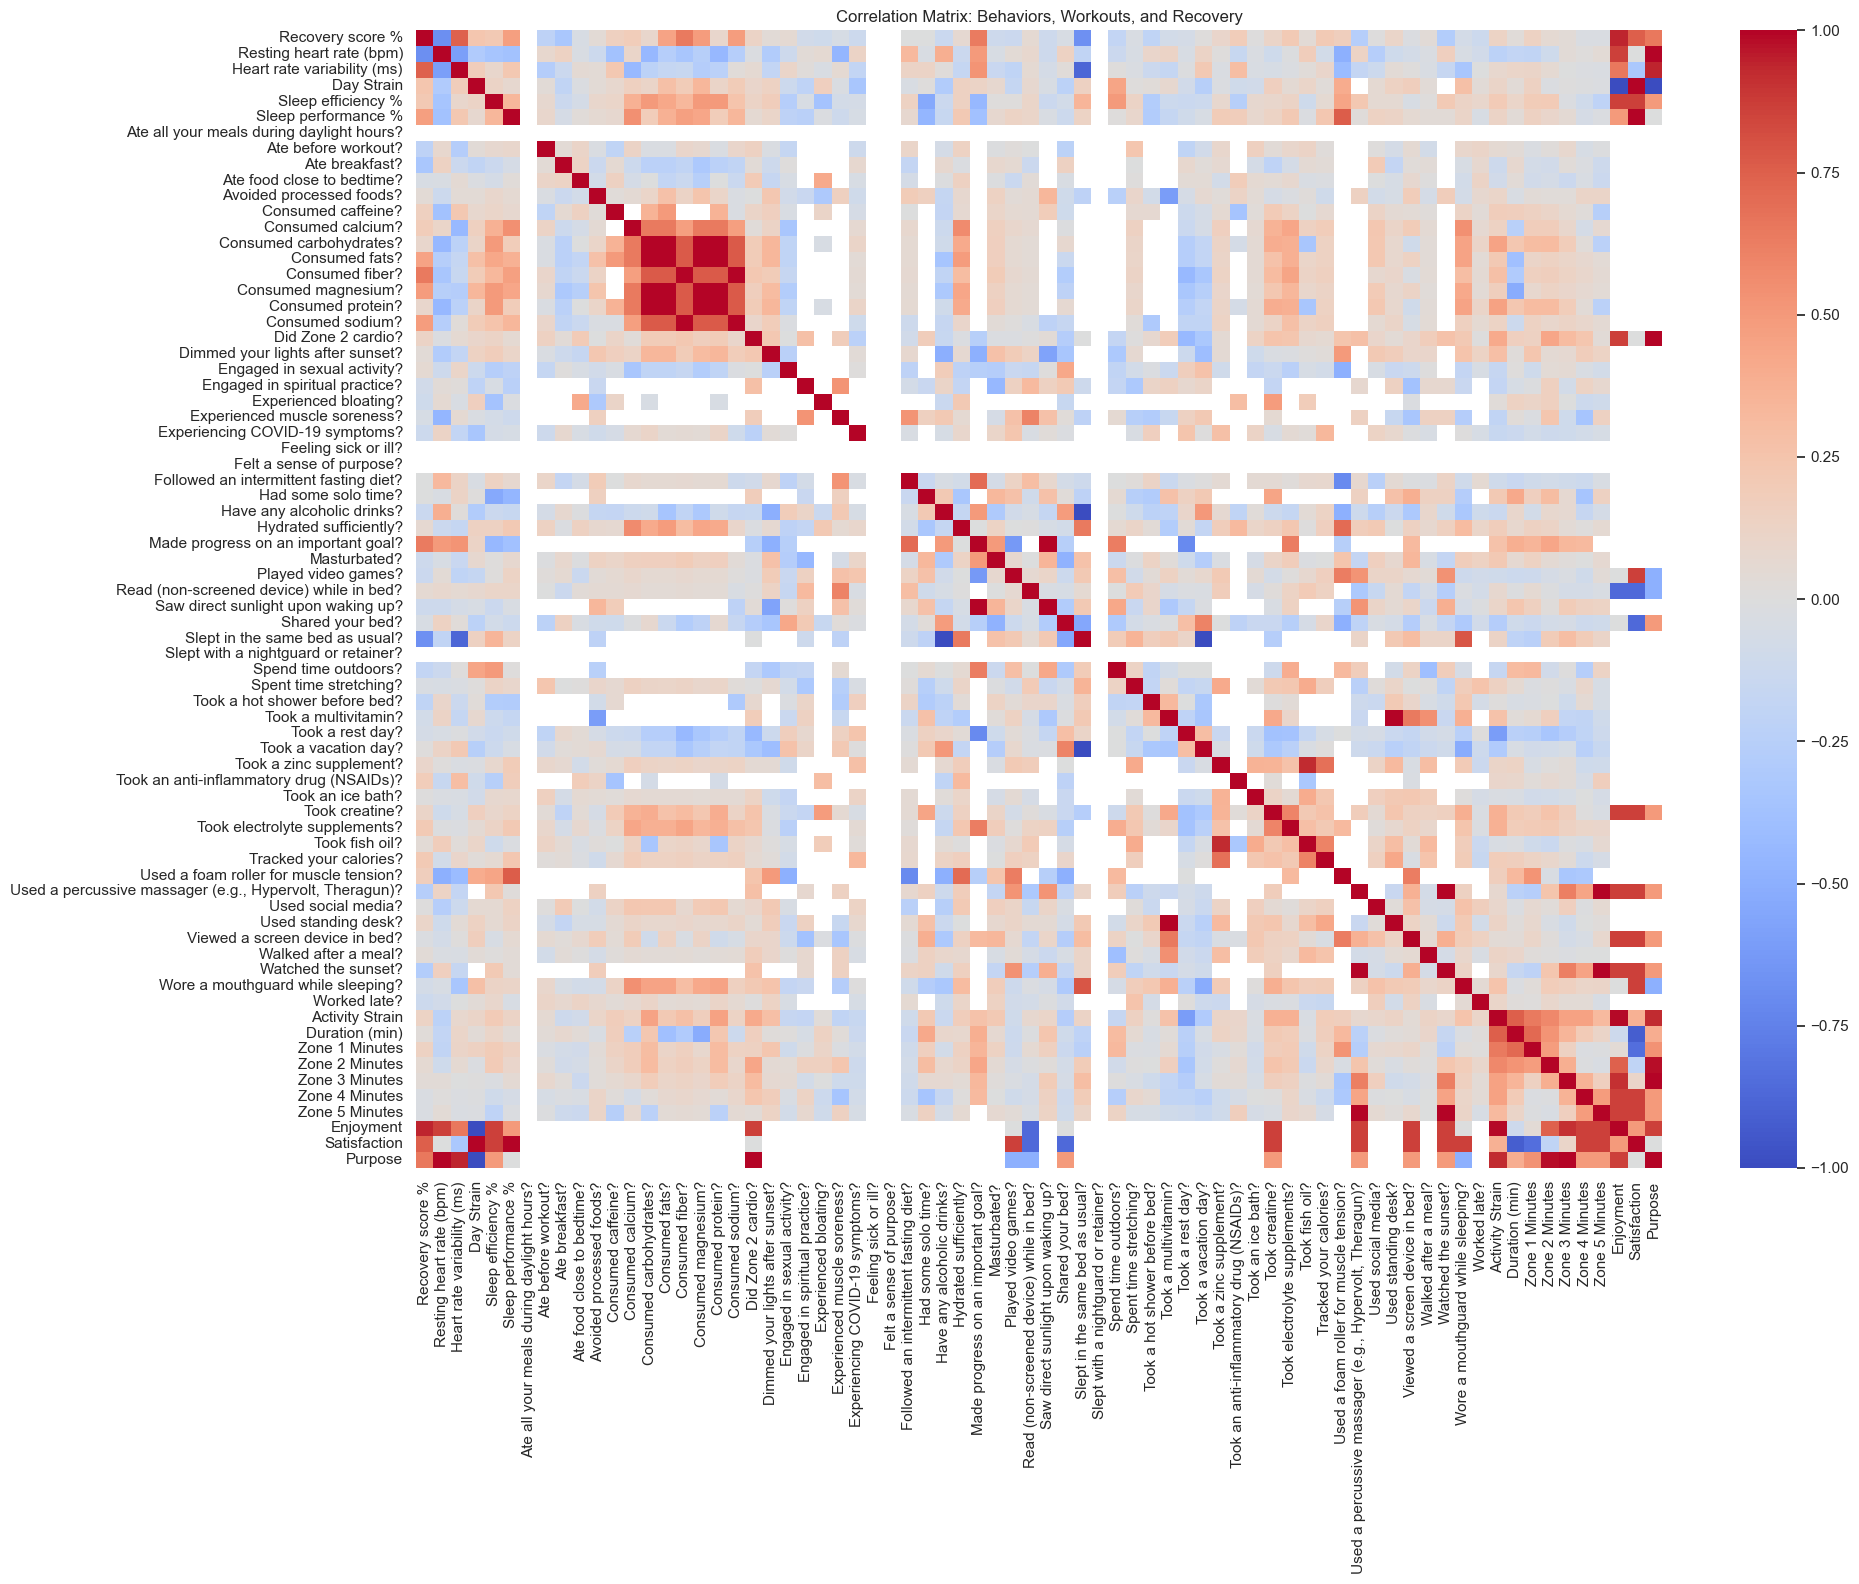

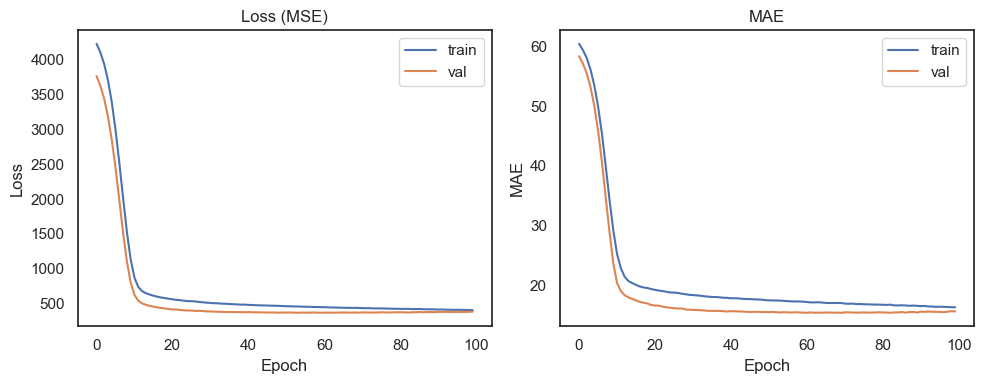

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import tempfile

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

try:
    import onnxruntime as ort
    import tf2onnx
except Exception:
    ort = None
    tf2onnx = None

# Set plotting style
sns.set_theme(style="white")

DATA_DIR = "my_whoop_data_2026_02_11"
DEFAULT_RECOVERY_THRESHOLD = 60

def report_compute_devices():
    print("\n--- Compute Devices ---")
    devices = tf.config.list_physical_devices()
    if not devices:
        print("TensorFlow sees no devices; using CPU by default.")
        return
    for d in devices:
        print(f"TensorFlow device: {d.device_type} - {d.name}")
    print("Note: Intel AI Boost NPU is used via ONNX Runtime + OpenVINO for inference.")

def build_onnx_session(model, input_dim):
    if ort is None or tf2onnx is None:
        print("ONNX Runtime or tf2onnx not installed; NPU inference disabled.")
        return None, None
    onnx_path = "recovery_model.onnx"
    try:
        spec = (tf.TensorSpec((None, input_dim), tf.float32, name="input"),)
        tf2onnx.convert.from_keras(model, input_signature=spec, output_path=onnx_path, opset=13)
        providers = ["OpenVINOExecutionProvider", "CPUExecutionProvider"]
        provider_options = [{"device_type": "NPU"}, {}]
        try:
            session = ort.InferenceSession(onnx_path, providers=providers, provider_options=provider_options)
            print("ONNX Runtime providers:", session.get_providers())
        except Exception as e:
            print(f"OpenVINO NPU session failed; falling back to CPU. Details: {e}")
            session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
            print("ONNX Runtime providers:", session.get_providers())
        input_name = session.get_inputs()[0].name
        return session, input_name
    except Exception as e:
        print(f"ONNX export/session failed: {e}")
        return None, None

def explain_training_setup(features, model_df, X_train, X_test):
    print("\n--- Training Overview ---")
    print(f"Total samples after feature engineering: {len(model_df)}")
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    print(f"Features ({len(features)}): {features}")
    print("We scale features to zero mean / unit variance to stabilize training.")
    print("Loss: MSE (penalizes larger errors). Metric: MAE (average absolute error).")
    print("Validation split shows how well the model generalizes.")

class TrainingNarrator(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.mae = []
        self.val_mae = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))
        self.mae.append(logs.get("mae"))
        self.val_mae.append(logs.get("val_mae"))
        if (epoch + 1) % 5 == 0 or epoch == 0:
            msg = (
                f"Epoch {epoch + 1}: loss={logs.get('loss'):.4f}, "
                f"val_loss={logs.get('val_loss'):.4f}, "
                f"mae={logs.get('mae'):.3f}, "
                f"val_mae={logs.get('val_mae'):.3f}"
            )
            print(msg)
            if len(self.val_losses) >= 3:
                if self.val_losses[-1] is not None and self.losses[-1] is not None:
                    if self.val_losses[-1] > min(self.val_losses[:-1]) and self.losses[-1] < self.losses[0]:
                        print("  Note: training loss down but validation loss up -> possible overfitting.")
                    elif self.val_losses[-1] < self.val_losses[0]:
                        print("  Note: validation loss improving -> better generalization.")

def plot_learning_curves(history):
    if history is None:
        return
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get("loss", []), label="train")
    plt.plot(history.history.get("val_loss", []), label="val")
    plt.title("Loss (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get("mae", []), label="train")
    plt.plot(history.history.get("val_mae", []), label="val")
    plt.title("MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_curves.png")
    print("Training curves saved to training_curves.png")

def permutation_sensitivity(model, X_test, y_test, feature_names):
    if len(X_test) == 0:
        return
    baseline_pred = model.predict(X_test, verbose=0).reshape(-1)
    baseline_mae = np.mean(np.abs(baseline_pred - y_test))
    impacts = []
    for i, name in enumerate(feature_names):
        X_perm = X_test.copy()
        np.random.shuffle(X_perm[:, i])
        pred = model.predict(X_perm, verbose=0).reshape(-1)
        mae = np.mean(np.abs(pred - y_test))
        impacts.append((name, mae - baseline_mae))
    impacts.sort(key=lambda x: x[1], reverse=True)
    print("\n--- Feature Sensitivity (Permutation) ---")
    print("How much MAE worsens when a feature is shuffled:")
    for name, delta in impacts[:5]:
        print(f"  {name}: +{delta:.3f} MAE")

def load_data():
    print("Loading data...")
    try:
        journal = pd.read_csv(os.path.join(DATA_DIR, "journal_entries.csv"))
        phys = pd.read_csv(os.path.join(DATA_DIR, "physiological_cycles.csv"))
        sleeps = pd.read_csv(os.path.join(DATA_DIR, "sleeps.csv"))
        workouts = pd.read_csv(os.path.join(DATA_DIR, "workouts.csv"))
        happiness = pd.read_csv(os.path.join(DATA_DIR, "subjective_happiness.csv"))
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return None, None, None, None, None
    return journal, phys, sleeps, workouts, happiness

def process_journal(journal_df):
    print("Processing Journal Entries...")
    journal_df['Cycle start time'] = pd.to_datetime(journal_df['Cycle start time'])
    journal_df = journal_df.drop_duplicates(subset=['Cycle start time', 'Question text'])
    journal_df['Answered yes'] = journal_df['Answered yes'].astype(str).str.lower().map({'true': 1, 'false': 0})
    pivoted = journal_df.pivot(index='Cycle start time', columns='Question text', values='Answered yes')
    return pivoted

def process_physiological(phys_df):
    print("Processing Physiological Cycles...")
    phys_df['Cycle start time'] = pd.to_datetime(phys_df['Cycle start time'])
    phys_df['Wake onset'] = pd.to_datetime(phys_df['Wake onset'])
    phys_df['Date'] = phys_df['Wake onset'].dt.normalize()
    cols = ['Cycle start time', 'Date', 'Recovery score %', 'Resting heart rate (bpm)', 'Heart rate variability (ms)', 'Day Strain']
    cols = [c for c in cols if c in phys_df.columns]
    return phys_df[cols]

def process_sleeps(sleeps_df):
    print("Processing Sleeps...")
    sleeps_df['Cycle start time'] = pd.to_datetime(sleeps_df['Cycle start time'])
    cols = ['Cycle start time', 'Sleep efficiency %', 'Sleep performance %']
    return sleeps_df[cols]

def process_workouts(workouts_df):
    print("Processing Workouts...")
    workouts_df['Workout start time'] = pd.to_datetime(workouts_df['Workout start time'])
    workouts_df['Workout Date'] = workouts_df['Workout start time'].dt.normalize()
    
    for i in range(1, 6):
        col_pct = f'HR Zone {i} %'
        col_min = f'Zone {i} Minutes'
        if col_pct in workouts_df.columns:
            workouts_df[col_min] = workouts_df['Duration (min)'] * (workouts_df[col_pct] / 100.0)
    
    agg_funcs = {'Activity Strain': 'sum', 'Duration (min)': 'sum'}
    for i in range(1, 6):
        col_min = f'Zone {i} Minutes'
        if col_min in workouts_df.columns:
            agg_funcs[col_min] = 'sum'
            
    aggregated = workouts_df.groupby('Workout Date').agg(agg_funcs).reset_index()
    # Shift Date: Workout Date (Day N-1) -> Affects Recovery Date (Day N)
    aggregated['Date'] = aggregated['Workout Date'] + pd.Timedelta(days=1)
    return aggregated

def process_happiness(happiness_df):
    print("Processing Happiness...")
    happiness_df['Date'] = pd.to_datetime(happiness_df['Date']).dt.normalize()
    return happiness_df

def train_recovery_model(df):
    print("\n--- Training Deep Learning Model for Strain Optimization ---")
    
    # Sort by date to ensure lags are correct
    df = df.sort_values('Date')
    
    # Feature Engineering
    # We want to predict Next Day Recovery (N+1)
    # Using: Recovery(N), Sleep(N), Strain(N), Strain(N-1)...Strain(N-7)
    
    # Target: Next Day Recovery
    # Note: 'Recovery score %' in `df` is already for Day N (merged on Date).
    # So we want to predict `df['Recovery score %'].shift(-1)`
    df['Target_Next_Recovery'] = df['Recovery score %'].shift(-1)
    
    # Features
    # Current Day N features
    # features = ['Recovery score %', 'Sleep efficiency %', 'Activity Strain'] # REMOVED to avoid duplication
    features = []
    
    # Past Strains: Strain(N) is 'Activity Strain'.
    # We need Strain(N-1) ... Strain(N-7).
    # However, 'Activity Strain' in `df` is ALREADY shifted in `process_workouts`
    # In `process_workouts`: `Date` = `Workout Date` + 1.
    # So `df.loc[Date=T, 'Activity Strain']` is actually the strain performed on T-1.
    
    # Let's clarify the timeline:
    # Date T: We wake up, measure Recovery(T). We sleep T-1 -> T.
    # The 'Activity Strain' merged on Date T corresponds to workout on T-1.
    
    # Optimization Goal:
    # We are at Date T (morning). We have Recovery(T).
    # We want to decide Strain(T).
    # This Strain(T) will affect Recovery(T+1).
    
    # So the model should predict Recovery(T+1).
    # Inputs:
    # - Recovery(T) (Morning state)
    # - Strain(T) (The decision variable - workout we will do today)
    # - Strain(T-1) (Yesterday's workout - already in `df` at Date T)
    # - Strain(T-2)... (Fatigue history)
    
    # In `df`, the row for Date T contains:
    # - Recovery(T)
    # - Activity Strain (Workout on T-1)
    
    # So to get Strain(T) as a feature for Row T, we actually need `Activity Strain` from Row T+1.
    # But Row T+1 doesn't exist yet when we are predicting.
    # So we are building a model where:
    # Row T features:
    # - Recovery(T)
    # - Strain(T) (Future variable relative to T's row data, but we can shift it back)
    # - Strain(T-1) (Current row's 'Activity Strain')
    # - Strain(T-2) (Lag 1 of 'Activity Strain')
    # ...
    
    # Let's realign features to be intuitive:
    # Let's Create 'Proposed_Strain_Today' which is `Activity Strain` shifted by -1 (from T+1 to T).
    df['Proposed_Strain_Today'] = df['Activity Strain'].shift(-1)
    
    # Create Lag features for history (Strain T-1, T-2...)
    # Strain T-1 is `Activity Strain` at row T.
    # Strain T-2 is `Activity Strain` at row T shifted +1 (Lag 1)
    for i in range(1, 8):
        df[f'Strain_Lag_{i}'] = df['Activity Strain'].shift(i-1) 
        features.append(f'Strain_Lag_{i}')
    
    # Add Proposed_Strain_Today to features
    features = ['Recovery score %', 'Sleep efficiency %', 'Proposed_Strain_Today'] + features
    
    # Drop NaN rows created by shifting
    model_df = df.dropna(subset=['Target_Next_Recovery', 'Proposed_Strain_Today'] + features)
    
    if len(model_df) < 50:
        print("Not enough data points for Deep Learning (<50). Skipping.")
        return None, None, features, None, None
        
    X = model_df[features].values
    y = model_df['Target_Next_Recovery'].values
    
    # Scale Data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    explain_training_setup(features, model_df, X_train, X_test)
    
    # Define Model
    model = keras.Sequential([
        keras.Input(shape=(len(features),)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae'])
    
    # Train
    print(f"Training on {len(X_train)} samples...")
    narrator = TrainingNarrator()
    history = model.fit(
        X_train, y_train,
        epochs=100,
        validation_split=0.2,
        verbose=1,
        batch_size=16,
        callbacks=[narrator]
    )
    
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model Trained. Test MAE: {mae:.2f}% (Average Error in Recovery Score prediction)")
    plot_learning_curves(history)
    permutation_sensitivity(model, X_test, y_test, features)
    
    onnx_session, onnx_input_name = build_onnx_session(model, len(features))
    return model, scaler, features, onnx_session, onnx_input_name

def predict_optimal_strain(model, scaler, feature_names, df, onnx_session=None, onnx_input_name=None, min_recovery=DEFAULT_RECOVERY_THRESHOLD):
    if model is None:
        return

    print(f"\n--- Optimizing Strain for Tomorrow (Target >= {min_recovery}%) ---")
    
    # Sort and clean
    df = df.sort_values('Date')
    
    # Get the most recent valid day's data (State T)
    # We need Recovery(T) and Sleep(T) to be present.
    valid_df = df.dropna(subset=['Recovery score %', 'Sleep efficiency %'])
    
    if len(valid_df) == 0:
        print("No valid data found for prediction.")
        return

    last_row = valid_df.iloc[-1]
    
    # Prepare base features
    # Recovery(T)
    rec_t = last_row['Recovery score %']
    # Sleep(T) (Assume available, or use mean if missing/future)
    # For simulation, we use the value from the last row (Last night's sleep)
    sleep_t = last_row['Sleep efficiency %']
    
    # Strain History
    # Strain(T-1) is `Activity Strain` in last_row
    strain_t_minus_1 = last_row['Activity Strain']
    
    # We need Strains T-2...T-7
    # Get history prior to current date
    current_date = last_row['Date']
    history_df = df[df['Date'] < current_date].sort_values('Date')
    
    # Get last 6 strains (T-2 to T-7)
    past_strains = history_df['Activity Strain'].tail(6).values[::-1]
    
    # Combine T-1 and T-2...T-7
    strain_history = np.concatenate(([strain_t_minus_1], past_strains))
    
    # Pad if not enough history
    if len(strain_history) < 7:
        strain_history = np.pad(strain_history, (0, 7-len(strain_history)), 'constant')
    
    # Loop to find optimal Strain(T)
    print(f"Current State (Day N): Recovery={rec_t}%, Sleep={sleep_t}%, Prev Strain={strain_t_minus_1}")
    print("Simulating Strain(N) from 0 to 21...")
    
    best_strain = 0
    max_rec = -1e9
    best_recovery_strain = 0
    found_target = False
    
    results = []
    use_onnx = onnx_session is not None and onnx_input_name is not None
    if use_onnx:
        print("Using ONNX Runtime for inference (NPU if available).")
    else:
        print("Using TensorFlow for inference.")
    
    for strain_val in np.arange(0, 21.5, 0.5):
        # Construct Input Vector
        # Features order: ['Recovery score %', 'Sleep efficiency %', 'Proposed_Strain_Today', 'Strain_Lag_1'...'Strain_Lag_7']
        # Note: 'Strain_Lag_1' corresponds to Strain(T-1)
        
        input_vec = [rec_t, sleep_t, strain_val]
        # Add history (T-1 to T-7)
        input_vec.extend(strain_history[:7])
        
        # Reshape and Scale
        input_vec = np.array(input_vec).reshape(1, -1)
        input_vec_scaled = scaler.transform(input_vec)
        
        # Predict
        if use_onnx:
            ort_out = onnx_session.run(None, {onnx_input_name: input_vec_scaled.astype(np.float32)})
            pred_recovery = ort_out[0][0][0]
        else:
            pred_recovery = model.predict(input_vec_scaled, verbose=0)[0][0]
        results.append((strain_val, pred_recovery))
        
        if pred_recovery > max_rec:
            max_rec = pred_recovery
            best_recovery_strain = strain_val
            
        if pred_recovery >= min_recovery:
            found_target = True
            best_strain = strain_val
    
    print("\n*** BEST RECOVERY ***")
    print(f"Best predicted recovery: {max_rec:.1f}% at Strain {best_recovery_strain}")
    
    if found_target:
        pred_r = [r for s, r in results if s == best_strain][0]
        print(f"\n*** THRESHOLD RECOMMENDATION ***")
        print(f"Target >= {min_recovery}% Recovery: go up to Strain {best_strain}")
        print(f"Predicted Recovery: {pred_r:.1f}%")
    else:
        print(f"\n*** NO STRAIN MEETS {min_recovery}% THRESHOLD ***")
        print("Recommendation: pick the best-recovery strain above.")

def main():
    report_compute_devices()
    journal, phys, sleeps, workouts, happiness = load_data()
    if journal is None:
        return

    # 1. Process Main Data (Phys + Sleep + Journal)
    phys_proc = process_physiological(phys)
    sleeps_proc = process_sleeps(sleeps)
    journal_proc = process_journal(journal)
    
    # Merge Phys and Sleep
    main_df = pd.merge(phys_proc, sleeps_proc, on='Cycle start time', how='left')
    
    # Merge Journal
    main_df = pd.merge(main_df, journal_proc, left_on='Cycle start time', right_index=True, how='left')
    
    # 2. Process Workouts
    workouts_proc = process_workouts(workouts)
    
    # 3. Process Happiness
    happiness_proc = process_happiness(happiness)
    
    # 4. Final Merge on Date
    full_df = pd.merge(main_df, workouts_proc, on='Date', how='left')
    
    # Fill NaN for workout columns with 0
    workout_cols = ['Activity Strain', 'Duration (min)'] + [c for c in workouts_proc.columns if 'Zone' in c and 'Minutes' in c]
    workout_cols = [c for c in workout_cols if c in full_df.columns]
    full_df[workout_cols] = full_df[workout_cols].fillna(0)
    print(f"Filled NaN values with 0 for {len(workout_cols)} workout columns (rest days).")

    # Merge Happiness
    full_df = pd.merge(full_df, happiness_proc, on='Date', how='left')
    
    # 5. Correlation Analysis
    numeric_df = full_df.select_dtypes(include=['number'])
    corr_matrix = numeric_df.corr()
    
    target = 'Recovery score %'
    if target in corr_matrix.columns:
        print(f"\n--- Top 5 Positive Influences on {target} ---")
        correlations = corr_matrix[target].drop(target)
        print(correlations.sort_values(ascending=False).head(5))
        
        print(f"\n--- Top 5 Negative Influences on {target} ---")
        print(correlations.sort_values(ascending=True).head(5))

    # 6. Heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title("Correlation Matrix: Behaviors, Workouts, and Recovery")
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png")
    print("\nHeatmap saved to correlation_heatmap.png")
    
    # 7. Deep Learning & Optimization
    # We pass full_df. Copy it to avoid setting with copy warnings
    dl_df = full_df.copy()
    model, scaler, feature_names, onnx_session, onnx_input_name = train_recovery_model(dl_df)
    
    if model:
        predict_optimal_strain(model, scaler, feature_names, dl_df, onnx_session, onnx_input_name, DEFAULT_RECOVERY_THRESHOLD)

if __name__ == "__main__":
    main()
